In this notebook we train a RealNVP based flow model to approximate the Double Well Boltzmann Distribution.
Scroll down to the bottom for visualisation of results. 

In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
import normflow as nf
import matplotlib.pyplot as plt
import torch

from fab import FABModel, HamiltoneanMonteCarlo, Trainer, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from examples.make_flow import make_wrapped_normflowdist

## Configure Training

In [3]:
dim: int = 2
n_intermediate_distributions: int = 2
layer_nodes_per_dim = 10
batch_size: int = 128
n_iterations: int = 2500
n_eval = 100
eval_batch_size = batch_size * 10
n_plots: int = 5 # number of plots shows throughout tranining
lr: float = 1e-3
transition_operator_type: str = "hmc"  # "metropolis" or "hmc"
seed: int = 2 # this is the seed we use for the GMM problem specifically (it gives a nice spacing of distributions)
n_flow_layers: int = 10
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)

## Setup GMM target distribution

In [4]:
from fab.target_distributions import GMM
torch.manual_seed(seed)
target = GMM(dim=dim, n_mixes=4, min_cov=1, loc_scaling=10)
plotting_bounds = (-25, 25)

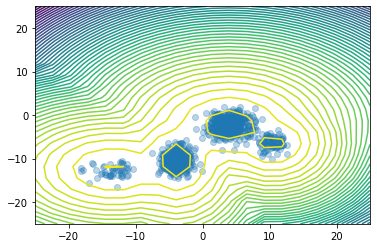

In [5]:
# plot target
fig, ax = plt.subplots()
samples = target.sample((1000,))
ax.plot(samples[:, 0], samples[:, 1], "o", alpha=0.3)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=50, ax=ax)

## Setup Flow
By wrapping the [normflow library](https://github.com/VincentStimper/normalizing-flows). 

In [6]:
flow = make_wrapped_normflowdist(dim, n_flow_layers=n_flow_layers, layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = True)

## Setup transition operator

In [7]:
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltoneanMonteCarlo(
        n_ais_intermediate_distributions=n_intermediate_distributions,
        n_outer=1,
        epsilon=1.0, L=2, dim=dim,
        step_tuning_method="p_accept")
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(n_transitions=n_intermediate_distributions,
                                     n_updates=5, adjust_step_size=True)
else:
    raise NotImplementedError

## Define model, trainer and plotter

In [8]:
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
scheduler = None
logger = ListLogger() # save training history

using linear spacing as there are only 2 intermediate distribution


In [9]:
def plot(fab_model, n_samples = 300):
    fig, axs = plt.subplots(1, 2)

    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50)
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50)

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,))
    plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)


    # plot ais samples
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0]
    plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
    axs[0].set_title("flow samples")
    axs[1].set_title("ais samples")
    plt.show()

In [10]:
# Create trainer
trainer = Trainer(model=fab_model, optimizer=optimizer, logger=logger, plot=plot,
                  optim_schedular=scheduler)

# Run with visualisation

loss: 7.492606092803735:   0%|                                                                                                                                                                        | 0/2500 [00:00<?, ?it/s]

non numeric history values being saved


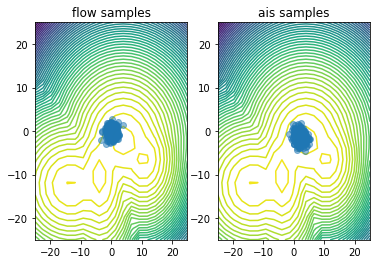

loss: 2.8645594131615946:   2%|██▍                                                                                                                                                           | 39/2500 [00:06<04:26,  9.23it/s]

1 nan/inf weights


loss: 1.6591168052736827:   2%|██▌                                                                                                                                                           | 41/2500 [00:06<04:24,  9.28it/s]

1 nan/inf weights
1 nan/inf weights


loss: 2.0257565233054424:   2%|██▊                                                                                                                                                           | 44/2500 [00:07<04:19,  9.48it/s]

1 nan/inf samples / log probs encountered.
2 nan/inf weights
4 nan/inf weights


loss: 1.0128446139385527:   2%|██▉                                                                                                                                                           | 47/2500 [00:07<04:16,  9.57it/s]

1 nan/inf weights
1 nan/inf weights


loss: 4.143541217200881:   2%|███                                                                                                                                                            | 49/2500 [00:07<04:23,  9.29it/s]

2 nan/inf weights
3 nan/inf weights


loss: 1.6863041660558138:   2%|███▏                                                                                                                                                          | 50/2500 [00:07<04:23,  9.28it/s]

4 nan/inf weights
1 nan/inf samples / log probs encountered.
2 nan/inf samples / log probs encountered.
1 nan/inf samples / log probs encountered.


loss: 1.6863041660558138:   2%|███▏                                                                                                                                                          | 51/2500 [00:08<16:10,  2.52it/s]

2 nan/inf samples / log probs encountered.


loss: 3.836946493334452:   2%|███▍                                                                                                                                                           | 55/2500 [00:09<07:17,  5.59it/s]

1 nan/inf samples / log probs encountered.
1 nan/inf weights
1 nan/inf samples / log probs encountered.


loss: 4.7567994256424155:   2%|███▌                                                                                                                                                          | 57/2500 [00:09<05:45,  7.07it/s]

1 nan/inf weights
1 nan/inf weights


loss: 2.240565387368789:   2%|███▊                                                                                                                                                           | 59/2500 [00:09<05:18,  7.67it/s]

2 nan/inf weights


loss: 1.725740282781506:   2%|███▉                                                                                                                                                           | 61/2500 [00:09<04:58,  8.17it/s]

1 nan/inf weights


loss: 1.6822878036338431:   3%|███▉                                                                                                                                                          | 63/2500 [00:09<04:37,  8.77it/s]

2 nan/inf weights
1 nan/inf weights


loss: 0.3698533769126646:  25%|███████████████████████████████████████▏                                                                                                                     | 624/2500 [01:32<03:24,  9.18it/s]

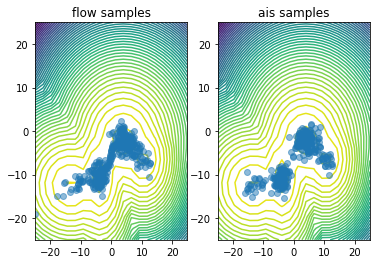

loss: 0.2452044727571101:  50%|█████████████████████████████████████████████████████████████████████████████▉                                                                              | 1249/2500 [03:06<02:15,  9.21it/s]

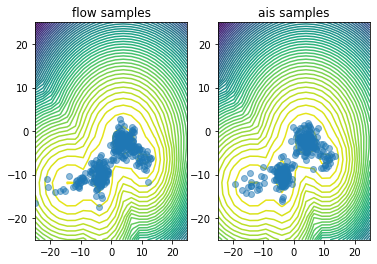

loss: 0.22195306608724596:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1874/2500 [04:39<01:25,  7.35it/s]

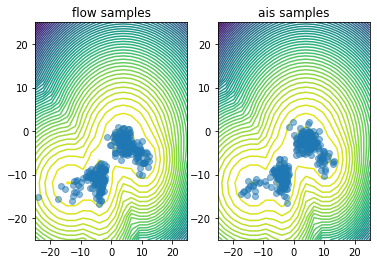

loss: 0.1612368568255076: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2499/2500 [06:13<00:00,  8.73it/s]

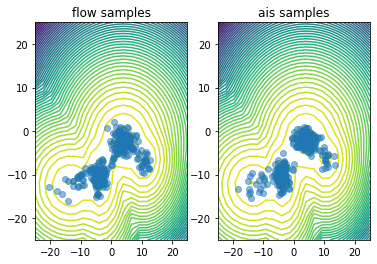

loss: 0.1612368568255076: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:15<00:00,  6.66it/s]


In [11]:
# the nan's that arrise during the training are typically extreme flow samples (e.g. x=[100, 100]), 
# which give Nan values for the target density. However, these do not harm long term training.
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size)

In the below plot:
ess = effective sample size
"Distance" refers to the distance moved during each intermediate transition. 

NaN encountered in ess_base history
NaN encountered in ess_ais history
NaN encountered in log_Z history
NaN encountered in average_distance history
NaN encountered in eval_ess_flow history
NaN encountered in eval_ess_ais history
NaN encountered in bias_normed history


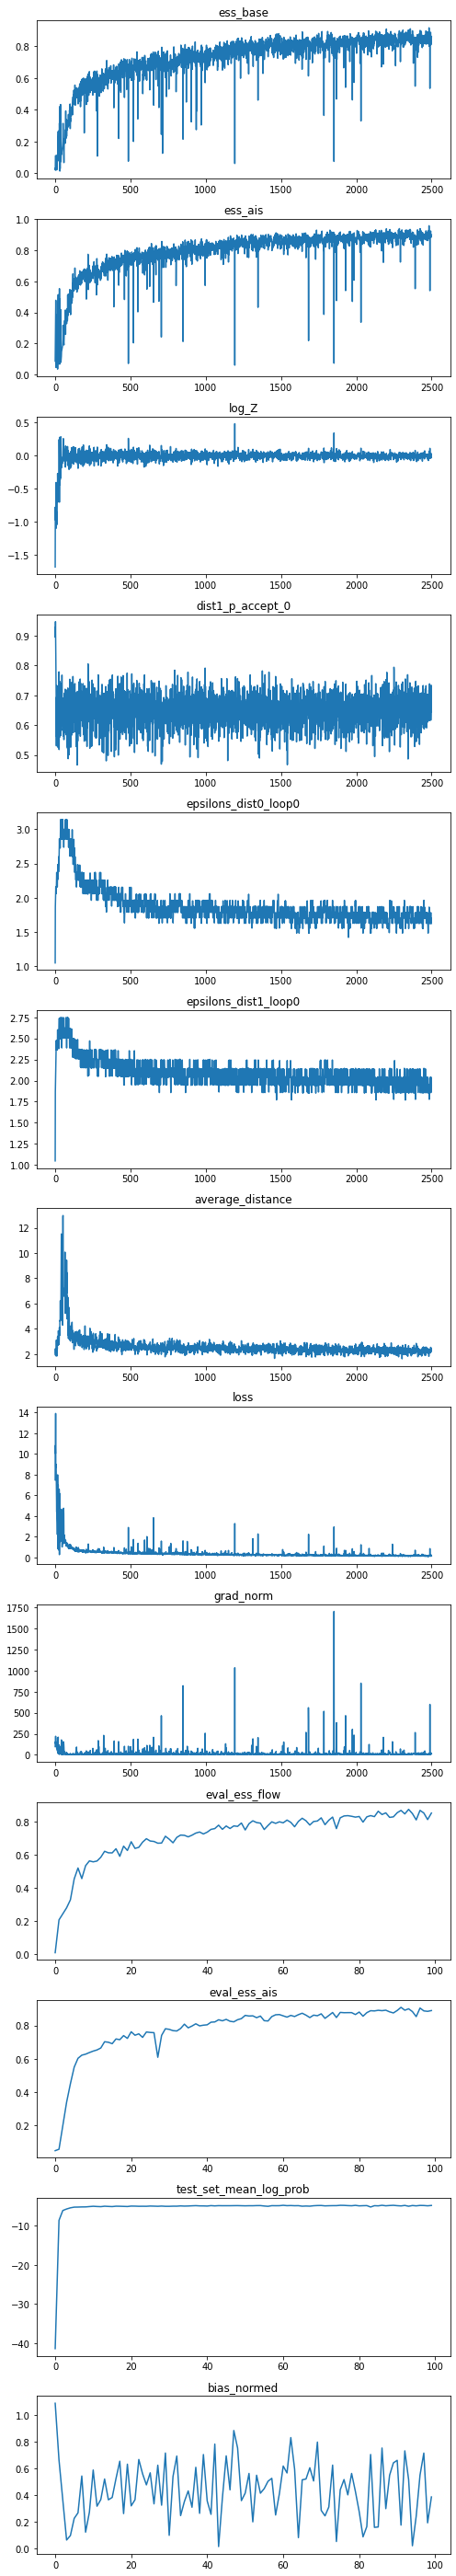

In [12]:
plot_history(logger.history)

## Visualise Trained Flow Model

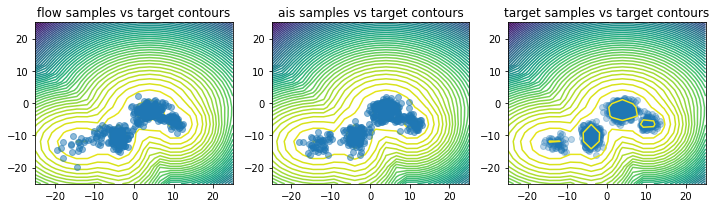

In [13]:
# plot samples on top of contours
n_samples = 500
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50)
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50)
# plot flow samples
samples_flow = fab_model.flow.sample((n_samples,))
plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)
axs[0].set_title("flow samples vs target contours")
# plot ais samples
samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                           logging=False)[0]
plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
axs[1].set_title("ais samples vs target contours")


samples = target.sample((1000,))
axs[2].plot(samples[:, 0], samples[:, 1], "o", alpha=0.3)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=50, ax=axs[2])
axs[2].set_title("target samples vs target contours")
plt.tight_layout()